# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.txa6yqsd3gcqqc22geq54j2udcxdxhwn.gfortran-win_amd64.dll
  stacklevel=1)


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


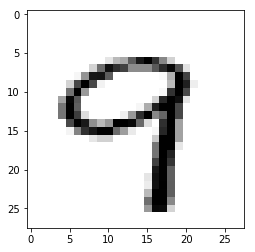

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)


plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

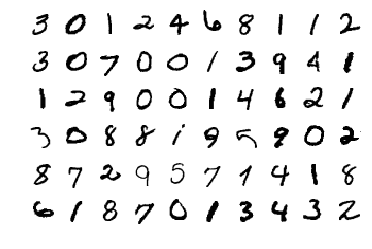

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
from torch.optim.lr_scheduler import StepLR
EPOCHS = 15
model =  Net().to(device)
init_learning_rate = 0.199
gamma= (init_learning_rate - (0.0001/EPOCHS))/init_learning_rate
optimizer = optim.SGD(model.parameters(), lr=init_learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    # Print Learning Rate
    print('LR:', scheduler.get_lr())
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13149306178092957 Batch_id=937 Accuracy=93.08: 100%|██████████████████████████| 938/938 [00:15<00:00, 61.20it/s]


LR: [0.19898666689000563]

Test set: Average loss: 0.0465, Accuracy: 9852/10000 (98.52%)

EPOCH: 1


Loss=0.04211203753948212 Batch_id=937 Accuracy=97.41: 100%|██████████████████████████| 938/938 [00:15<00:00, 62.50it/s]


LR: [0.19898000067000934]

Test set: Average loss: 0.0466, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.11526009440422058 Batch_id=937 Accuracy=97.84: 100%|██████████████████████████| 938/938 [00:14<00:00, 70.90it/s]


LR: [0.198973334673337]

Test set: Average loss: 0.0302, Accuracy: 9910/10000 (99.10%)

EPOCH: 3


Loss=0.03586879372596741 Batch_id=937 Accuracy=98.11: 100%|██████████████████████████| 938/938 [00:15<00:00, 68.92it/s]


LR: [0.19896666889998113]

Test set: Average loss: 0.0359, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.037759438157081604 Batch_id=937 Accuracy=98.26: 100%|█████████████████████████| 938/938 [00:15<00:00, 68.05it/s]


LR: [0.19896000334993424]

Test set: Average loss: 0.0234, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.0029557347297668457 Batch_id=937 Accuracy=98.44: 100%|████████████████████████| 938/938 [00:15<00:00, 59.63it/s]


LR: [0.19895333802318887]

Test set: Average loss: 0.0258, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.16519762575626373 Batch_id=937 Accuracy=98.54: 100%|██████████████████████████| 938/938 [00:16<00:00, 58.48it/s]


LR: [0.19894667291973753]

Test set: Average loss: 0.0267, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.09257446229457855 Batch_id=937 Accuracy=98.61: 100%|██████████████████████████| 938/938 [00:15<00:00, 59.95it/s]


LR: [0.19894000803957274]

Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.0031361281871795654 Batch_id=937 Accuracy=98.62: 100%|████████████████████████| 938/938 [00:15<00:00, 59.21it/s]


LR: [0.198933343382687]

Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.08138689398765564 Batch_id=937 Accuracy=98.69: 100%|██████████████████████████| 938/938 [00:15<00:00, 59.77it/s]


LR: [0.19892667894907287]

Test set: Average loss: 0.0211, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.0067202746868133545 Batch_id=937 Accuracy=98.71: 100%|████████████████████████| 938/938 [00:15<00:00, 68.11it/s]


LR: [0.19892001473872284]

Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.044682860374450684 Batch_id=937 Accuracy=98.76: 100%|█████████████████████████| 938/938 [00:16<00:00, 58.39it/s]


LR: [0.19891335075162944]

Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.0011552870273590088 Batch_id=937 Accuracy=98.77: 100%|████████████████████████| 938/938 [00:16<00:00, 58.48it/s]


LR: [0.1989066869877852]

Test set: Average loss: 0.0210, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.004728078842163086 Batch_id=937 Accuracy=98.90: 100%|█████████████████████████| 938/938 [00:15<00:00, 59.49it/s]


LR: [0.1989000234471826]

Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.19667109847068787 Batch_id=937 Accuracy=98.78: 100%|██████████████████████████| 938/938 [00:15<00:00, 59.43it/s]


LR: [0.1988933601298142]

Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

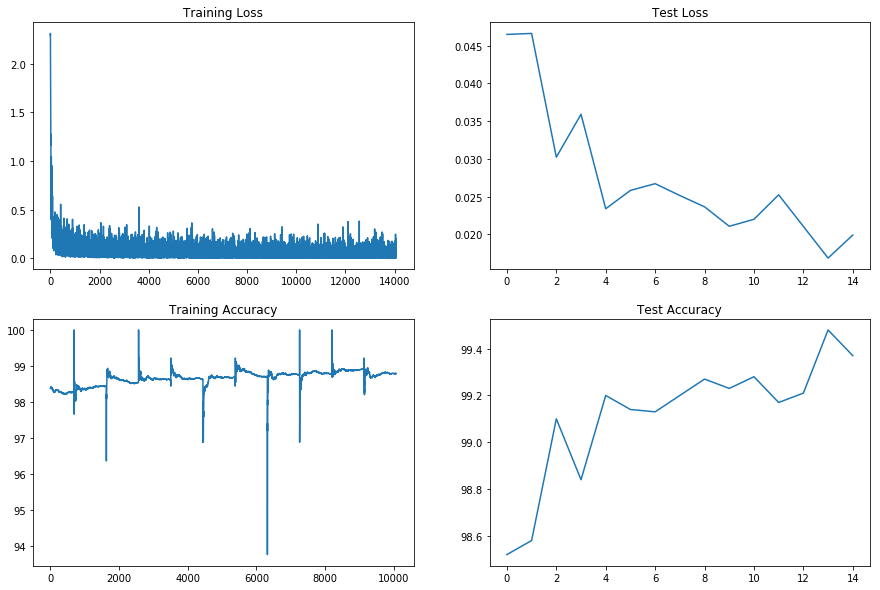

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")